# MLOps Datapath project
## Made by: Michael Andrés Mora P.

### Aim:

Predict share price according historical info from companies listed on Stock market.

#### Now, let's start with Data analysis info:

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy import stats
import joblib
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Declare general variables
NAME_COMPANY = "ISA_Historical_Info.csv"
PATH_RAW = f"../data/raw/{NAME_COMPANY}"
PATH_FINAL = f"../data/processed/processed_{NAME_COMPANY}"
BOX_COX_TRANSFORMER_PATH = "../config/model/transformers_boxcox.pkl"


In [4]:
# Visualize the first rows of our dataset
dataset_raw = pd.read_csv(PATH_RAW , sep=',')
dataset_raw.head()


FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/ISA_Historical_Info.csv'

In [4]:
# Statistical dataset info
dataset_raw.describe()

,Open,High,Low,Close
count,185.000000,185.000000,185.000000,185.000000
mean,105.541405,116.104324,94.947838,105.204703
std,98.879850,106.333497,91.219415,98.583153
min,10.000000,11.240000,5.550000,9.980000
25%,33.800000,36.140000,28.510000,33.450000
50%,62.980000,72.550000,58.000000,62.540000
75%,153.000000,169.190000,138.350000,153.300000
max,369.950000,404.000000,345.500000,367.900000


In [5]:
# Get the min and max dates of our market info Company
print(dataset_raw['Date'].min())
print(dataset_raw['Date'].max())

Apr-06
Sep-20


In [6]:
# Info about columns and type columns
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


In [7]:
# Become Date feature from object to date format
dataset_raw['Date'] = pd.to_datetime(dataset_raw['Date'], format='%b-%y')


In [8]:
# Validate this transformation
dataset_raw.head(3)

,Date,Open,High,Low,Close
0,2005-07-01,13.00,14.00,11.25,12.46
1,2005-08-01,12.58,14.88,12.55,13.42
2,2005-09-01,13.48,14.87,12.27,13.30


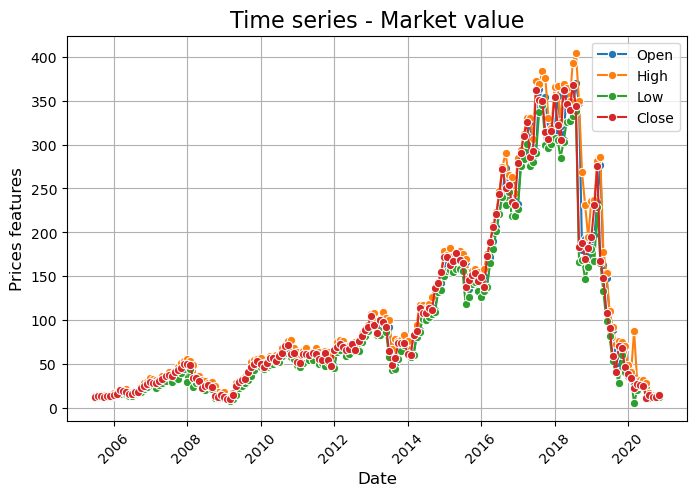

In [9]:
# Create with seaborn the time series to each feature
plt.figure(figsize=(8, 5))
sns.lineplot(x='Date', y='Open', data=dataset_raw, marker='o', label="Open")
sns.lineplot(x='Date', y='High', data=dataset_raw, marker='o', label="High")
sns.lineplot(x='Date', y='Low', data=dataset_raw, marker='o', label="Low")
sns.lineplot(x='Date', y='Close', data=dataset_raw, marker='o', label="Close")

# Personalizar el gráfico
plt.title('Time series - Market value', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Prices features', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [10]:
# Review the null values per feature
for x in (dataset_raw.columns):
    nulls_columns_x = dataset_raw[x].isnull().sum()
    print(f"Total null values to columns {x}: {nulls_columns_x}")

Total null values to columns Date: 0
Total null values to columns Open: 0
Total null values to columns High: 0
Total null values to columns Low: 0
Total null values to columns Close: 0


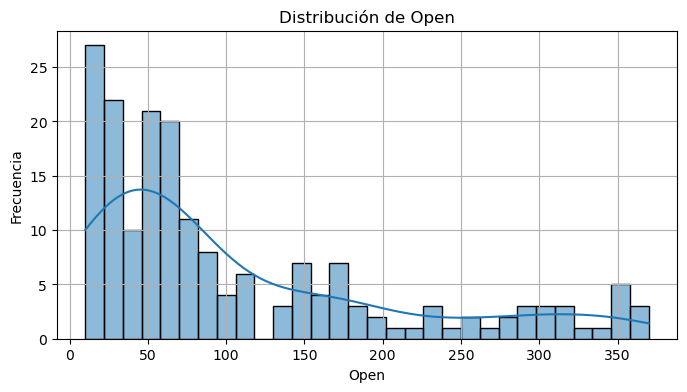

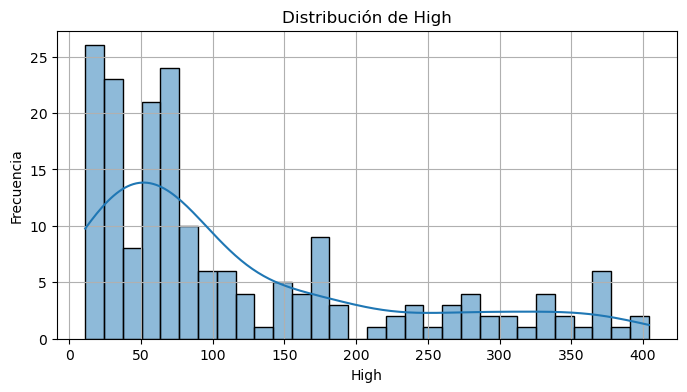

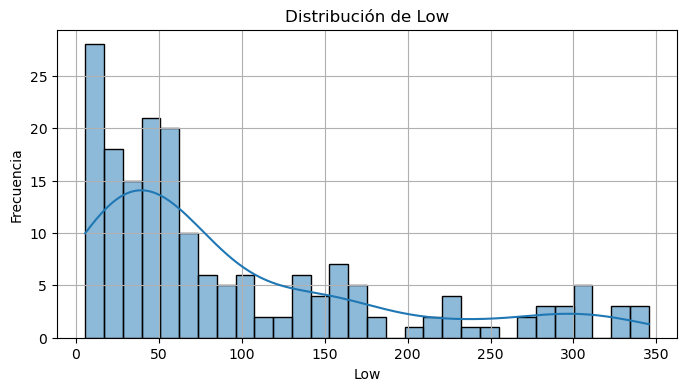

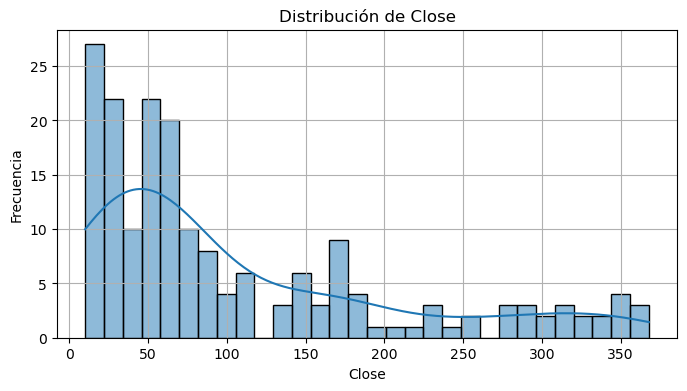

In [11]:
# Histograms per feature
for column in dataset_raw.select_dtypes(include='float64').columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(dataset_raw[column], kde=True, bins=30)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

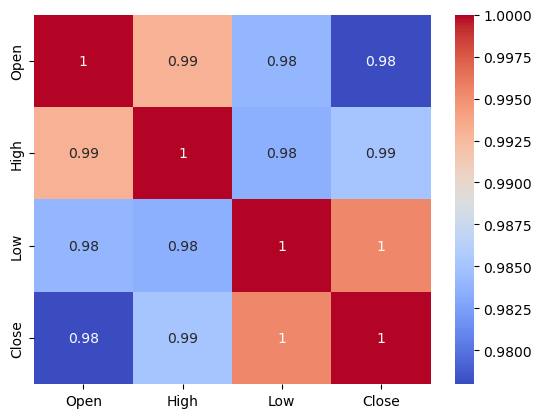

In [12]:
# Matrix correlation to prove multicolineality between features
correlation_matrix =dataset_raw.drop("Date", axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

#### Transformaciones por sesgo a la izquierda

In [13]:
# Aplicar Box-Cox a cada característica
features = ['Open', 'Close', 'Low', 'High']

dataset_to_transform = dataset_raw.drop('Date', axis=1)

# Crear el transformador Box-Cox usando PowerTransformer
boxcox_transformer = PowerTransformer(method='box-cox', standardize=False)

# Ajustar el transformador a los datos de entrenamiento
# Nota: Box-Cox requiere que todos los valores sean positivos
boxcox_transformer.fit(dataset_to_transform)

# Transformar los datos
df_transformed = boxcox_transformer.transform(dataset_to_transform)

# Convertir de nuevo a DataFrame para visualizar mejor
df_transformed = pd.DataFrame(df_transformed, columns=dataset_to_transform.columns)

print(df_transformed)



         Open      High       Low     Close
0    2.613965  2.682707  2.493722  2.568818
1    2.579869  2.745719  2.609925  2.645822
2    2.651627  2.745024  2.585922  2.636499
3    2.629821  2.716832  2.597132  2.612025
4    2.641559  2.673812  2.637552  2.645049
..        ...       ...       ...       ...
180  3.321191  3.413102  2.479479  2.525495
181  2.530892  2.893265  2.548898  2.716855
182  2.713010  2.777207  2.626752  2.624728
183  2.637661  2.683444  2.571966  2.565484
184  2.565748  2.747108  2.580710  2.738327

[185 rows x 4 columns]


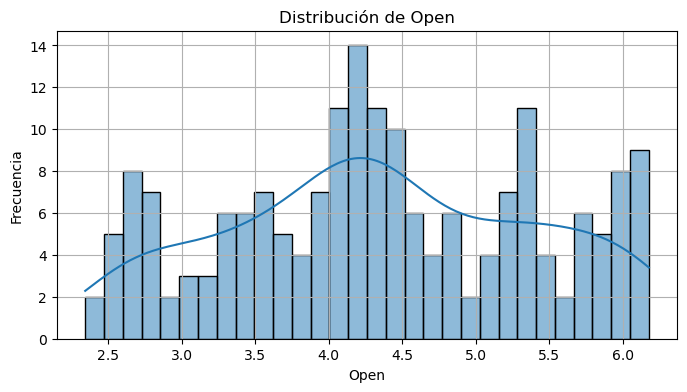

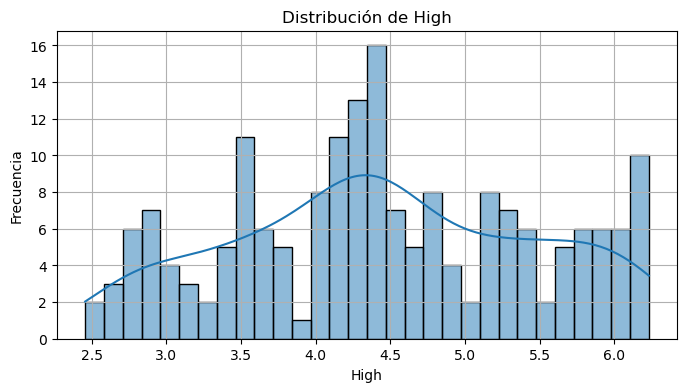

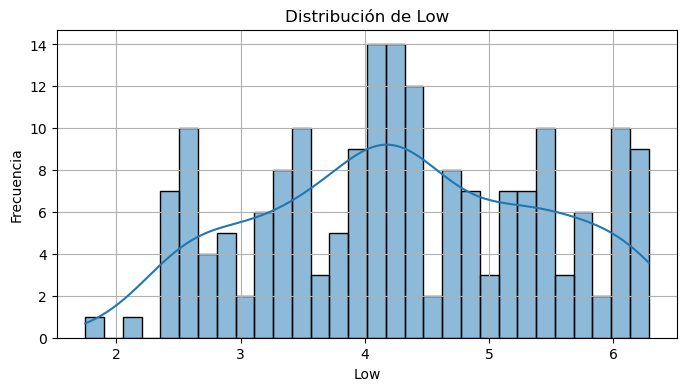

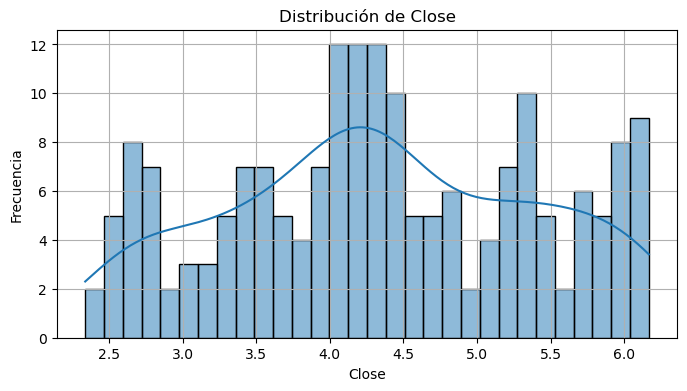

In [14]:
# Histograms per feature
for column in df_transformed.select_dtypes(include='float64').columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_transformed[column], kde=True, bins=30)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

In [15]:
# Guardar los transformadores usando joblib
joblib.dump(boxcox_transformer, BOX_COX_TRANSFORMER_PATH)

['../config/model/transformers_boxcox.pkl']

#### Standard scaler

In [16]:
# Scale our dataset
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(df_transformed))
scaled_data

,0,1,2,3
0,-1.671724,-1.762828,-1.622235,-1.709751
1,-1.704449,-1.700176,-1.518365,-1.635775
2,-1.635576,-1.700867,-1.539820,-1.644731
3,-1.656505,-1.728898,-1.529800,-1.668243
4,-1.645239,-1.771672,-1.493670,-1.636518
...,...,...,...,...
180,-0.992934,-1.036603,-1.634966,-1.751370
181,-1.751456,-1.553472,-1.572915,-1.567535
182,-1.576661,-1.668868,-1.503324,-1.656040
183,-1.648980,-1.762095,-1.552295,-1.712954


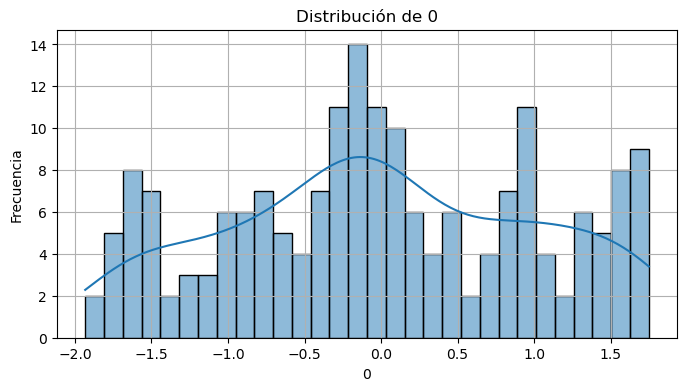

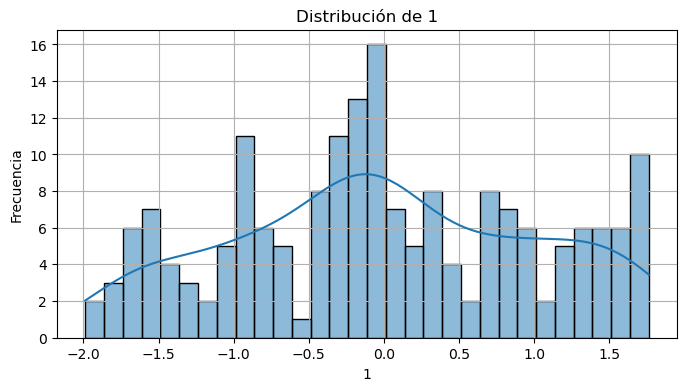

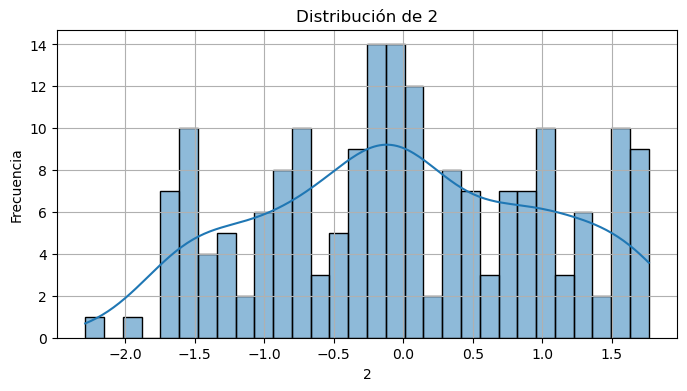

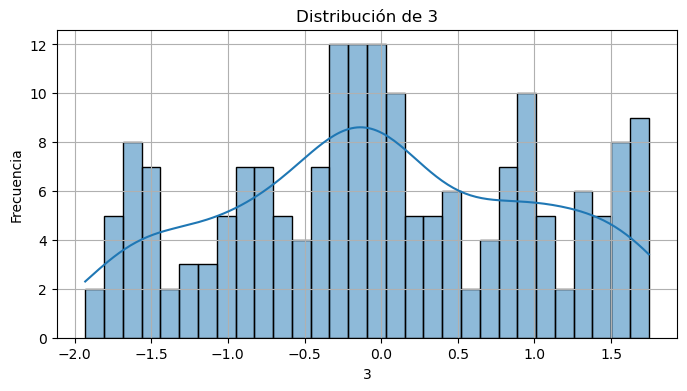

In [17]:
# Histograms per feature
for column in scaled_data.select_dtypes(include='float64').columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(scaled_data[column], kde=True, bins=30)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

### Save final transformed dataset

In [18]:
# Guardar el DataFrame en CSV
df_transformed.to_csv(PATH_FINAL, index=False)


In [21]:
# Cargar el transformador guardado
loaded_boxcox_transformer = joblib.load('../config/model/transformers_boxcox.pkl')

# Resultado de tu modelo o transformación aplicada anteriormente
resultado_transformado = [[6.114982, 0, 0, 0]]

# Aplicar la transformación inversa
resultado_original = loaded_boxcox_transformer.inverse_transform(resultado_transformado)

print(resultado_original[0][0])


349.0962407266731


/opt/anaconda3/envs/mlops_market_models/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


### 2. Prueba método dos con min max scaler.

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(dataset_raw)
